In [1]:
import pickle
import datetime

import numpy as np

import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

c:\Users\ogras\anaconda3\envs\centrex-tlf\lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.11.0+0.x64.w64.mingw32. You currently have `1.10.4+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.0+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=0, F1=3 / 2, F=2
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.P, J_ground=2, F1=3 / 2, F=2
    ),
]

polarizations = [
    [couplings.polarization_Z],
    [couplings.polarization_σm, couplings.polarization_σp],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [4]:
# ignore small decay to J=4
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=None,
    decay_channels=None,
    Jmax_X=3,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [5]:
odepars = lindblad_julia.odeParameters(
    # R0
    Ω0="ΩR0*variable_on_off(t, tonR0, toffR0, phaseR0)",
    ΩR0=1 * hamiltonian.Γ,
    δ0=0.0,  # detuning of the laser [rad/s]
    # laser phase modulation
    PZ0=1,
    # P2
    Ω1="ΩP2*variable_on_off(t, tonP2, toffP2, phaseP2)",
    ΩP2=1 * hamiltonian.Γ,
    δ1=0.0,
    P1="sin(ω1*t + φ1)",
    Pσm1="P1>0",
    Pσp1="P1<=0",
    ω1=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ1=0.0,  # polarization switching phase [rad]
    # on/off parameters
    tonR0=1.0,
    toffR0=0.0,
    tonP2=1.0,
    toffP2=0.0,
    phaseR0=0.0,
    phaseP2=0.0,
)

In [6]:
# on my home pc julia only loads on the third try, use try except in while loop to
# automatically retry
import logging

counter = 0
while True:
    try:
        obe_system = lindblad_julia.setup_OBE_system_julia(
            obe_system, transition_selectors, odepars, n_procs=6
        )
    except Exception as e:
        counter += 1
        logging.warning(f"Catch exception {counter}")
        logging.error(e)
        if counter > 3:
            raise e
        continue
    break

ERROR:root:Exception 'InitError: could not load library "libamd.dll"
The specified module could not be found. 
during initialization of module SuiteSparse_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    
ERROR:root:Exception 'InitError: could not load library "C:\Users\ogras\.julia\artifacts\89e2de680927805ce1a0b46b9ca742383fa224e7\bin\libsundials_sunlinsolklu.dll"
The specified module could not be found. 
during initialization of module Sundials_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    


In [7]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F₁ = 3/2, F = 2>"
states,
"|X, J = 0>",0.479679
"|X, J = 2>",0.520321


In [8]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)
indices_J0_F0 = states.QuantumSelector(
    J=0, F=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J0_F1 = states.QuantumSelector(
    J=0, F=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2_F3 = states.QuantumSelector(
    J=2, F=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

In [301]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=2, F=3, electronic=states.ElectronicState.X),
    obe_system.QN,
)

In [302]:
odepars.tonR0 = 1e-6
odepars.toffR0 = 1e-6
odepars.tonP2 = 1e-6
odepars.toffP2 = 1e-6
odepars.phaseR0 = 0.0
odepars.phaseP2 = np.pi
odepars.ΩR0 = 1 * hamiltonian.Γ
odepars.ΩP2 = 1 * hamiltonian.Γ

In [303]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 200e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6, reltol=1e-3, abstol=1e-7, save_everystep=True, callback=None
)

In [304]:
results = lindblad_julia.do_simulation_single(problem, config=config)


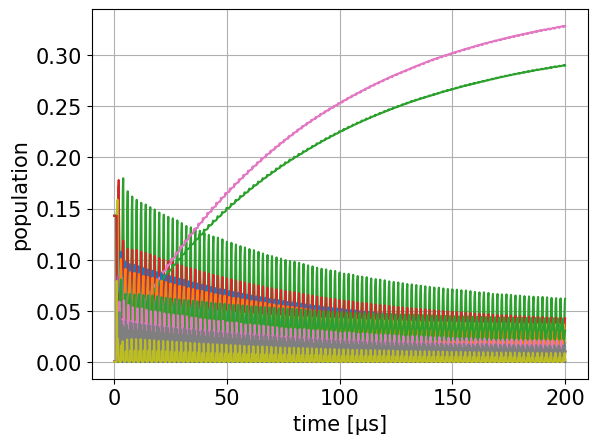

In [305]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y.T)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

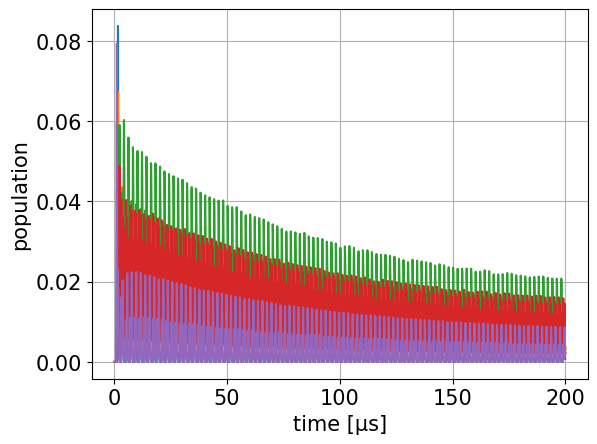

In [306]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

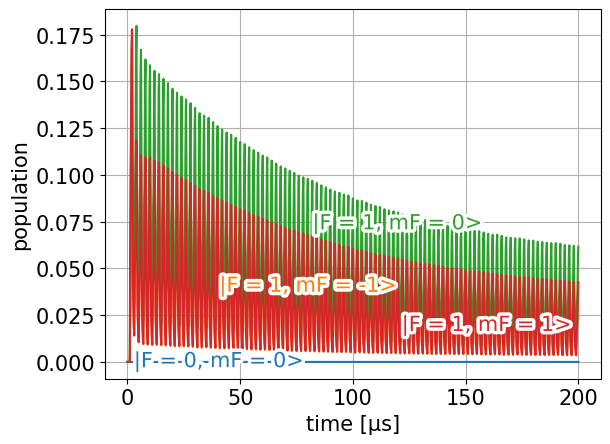

In [307]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J0
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J0].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

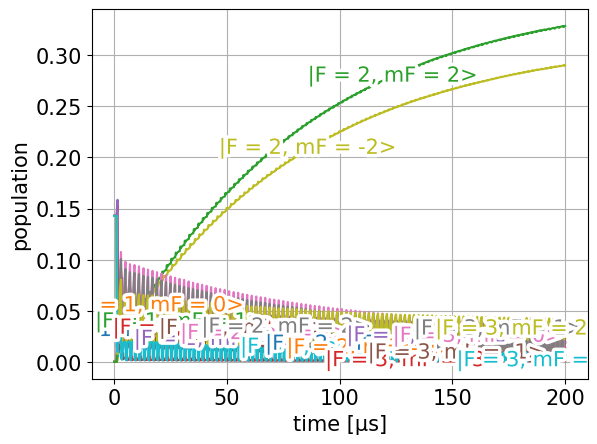

In [308]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J2
]
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J2].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

In [310]:
from scipy.integrate import trapezoid

photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")

# photons = 79.6


# Parameter scan

In [220]:
rabisR0 = np.logspace(-1, 1, 5) * hamiltonian.Γ
rabisP2 = (
    np.logspace(-1, 1, 5)
    * hamiltonian.Γ
    * np.abs(
        obe_system.couplings[0].main_coupling / obe_system.couplings[1].main_coupling
    )
)
onoff = np.arange(1e-6, 10e-6 + 1e-7, 5e-7)
pol_freqs = np.linspace(0, 2e-6, 11) * 2 * np.pi


In [221]:
scan_values = [rabisR0, rabisP2, onoff, onoff]
parameters = ["ΩR0", "ΩP2", "tonR0", "toffR0", "tonP2", "toffP2"]

In [222]:
values = np.array(np.meshgrid(*scan_values, indexing="ij")).T.reshape(
    -1, len(scan_values)
)
values = np.hstack([values, values[:, -1][:, np.newaxis], values[:, -1][:, np.newaxis]])
values[:, -3] = values[:, -3]

In [223]:
# F=2 excited state so 5 states
save_idxs_excited = save_idxs[-5:]

In [224]:
output_function = lindblad_julia.setup_state_integral_calculation_state_idxs(
    nphotons=True, Γ=hamiltonian.Γ
)

In [232]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    distributed_method="EnsembleDistributed()",
    save_everystep=True,
    save_idxs=save_idxs_excited,
    callback=None,
    reltol=1e-3,
    abstol=1e-6,
    saveat=1e-6,
    trajectories=100,
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 200e-6))


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=values.T,
    output_func=output_function,
    zipped=True,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

In [233]:
%%time
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

CPU times: total: 328 ms
Wall time: 20.9 s


In [234]:
results_scan = lindblad_julia.get_results_parameter_scan(ensemble_problem)

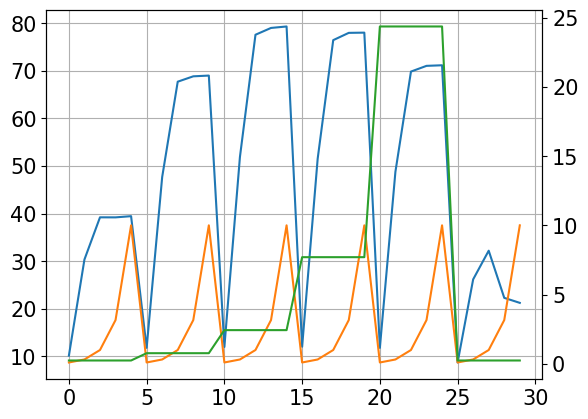

In [242]:
mask = np.s_[:30]

fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.plot(results_scan.results[mask])
ax1.plot(results_scan.scan_values[0, :100][mask] / hamiltonian.Γ, color="C1")
ax1.plot(results_scan.scan_values[1, :100][mask] / hamiltonian.Γ, color="C2")

ax.grid()


In [236]:
results_scan.scan_values[:, np.argmax(results_scan.results)]

array([9.80176908e+07, 2.38728552e+07, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06])

In [ ]:
results_scan.scan_values[:, np.argmax(results_scan.results)]